# Import Required Libraries 

In [2]:
import os
import random

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from PIL import Image
from torch.utils.data import DataLoader, Dataset

In [3]:
from dotenv import load_dotenv
# Load .env files
try:
    load_dotenv()
except:
    print("Couldn't load .env file")

# Get environmet variables
traffic_sign_dataset_dir = os.getenv('TRAFFIC_SIGN_DIR')

# Loading The Data

In [4]:
meta_df = pd.read_csv(traffic_sign_dataset_dir + '/Meta.csv')
train_df = pd.read_csv(traffic_sign_dataset_dir + '/Train.csv')
test_df = pd.read_csv(traffic_sign_dataset_dir + '/Test.csv')

In [5]:
train_data_path = os.path.join(traffic_sign_dataset_dir, 'Train')
test_data_path = os.path.join(traffic_sign_dataset_dir, 'Test')
meta_data_path = os.path.join(traffic_sign_dataset_dir, 'Meta')

# Exploring The Data

In [6]:
#exploring Meta.csv file

print("")
print("------------------------------------------------")
print(meta_df.head())
print("------------------------------------------------")

print("number of classes in the dataset:", meta_df.ClassId.nunique())
print("number of Shape Ids in the dataset:", meta_df.ShapeId.nunique())
print("number of Color Ids in the dataset:", meta_df.ColorId.nunique())
print("number of Sign Ids in the dataset:", meta_df.SignId.nunique())
print("")


------------------------------------------------
          Path  ClassId  ShapeId  ColorId SignId
0  Meta/27.png       27        0        0   1.32
1   Meta/0.png        0        1        0   3.29
2   Meta/1.png        1        1        0   3.29
3  Meta/10.png       10        1        0   3.27
4  Meta/11.png       11        0        0   1.22
------------------------------------------------
number of classes in the dataset: 43
number of Shape Ids in the dataset: 5
number of Color Ids in the dataset: 4
number of Sign Ids in the dataset: 32


## Plotting the original Traffic signs

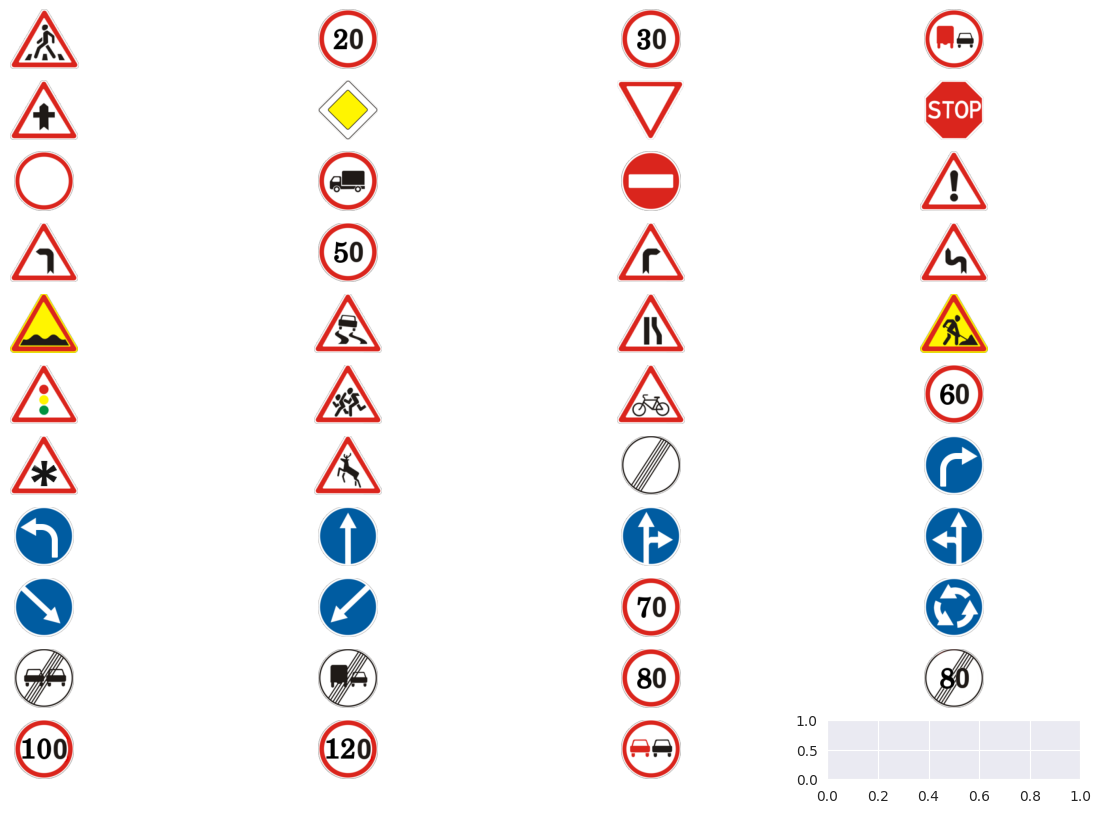

In [7]:
signs = [os.path.join(traffic_sign_dataset_dir, meta_df.Path.to_list()[i]) for i in range(43)]
fig, axes = plt.subplots(11, 4, figsize=(15, 10))
for i, image_path in enumerate(signs):
    image = Image.open(image_path)
    row = i // 4
    col = i % 4
    axes[row, col].imshow(image)
    axes[row, col].axis('off')

plt.show();

In [8]:
#exploring Train.csv file

print("")
print("------------------------------------------------")
print(train_df.head())
print("------------------------------------------------")

print("number of Training Samples in the dataset:", train_df.shape[0])
print("number of Test Samples in the dataset:", test_df.shape[0])
print("number of Classes in the dataset:", train_df["ClassId"].nunique())
print("The Maximum Width:", train_df["Width"].max())
print("The Maximum Height:", train_df["Height"].max())


------------------------------------------------
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  
------------------------------------------------
number of Training Samples in the dataset: 39209
number of Test Samples in the dataset: 12630
number of Classes in the dataset: 43
The Maximum Width: 243
The Maximum Height: 225


## The Distribution of the Class labels in the dataset 

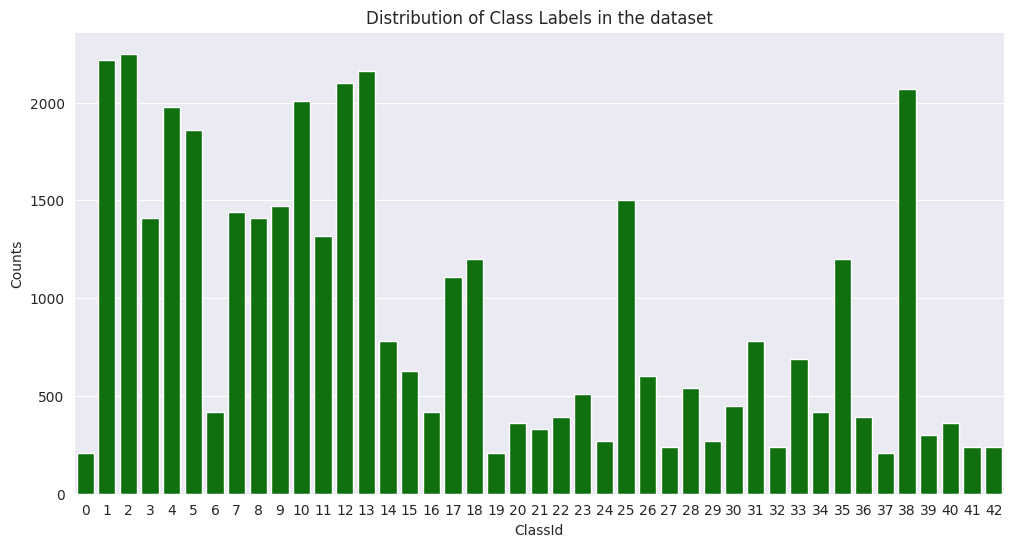

In [9]:
classes = train_df["ClassId"].value_counts().head(43)
plt.figure(figsize=(12, 6))
plt.title("Distribution of Class Labels in the dataset")
plt.ylabel('Counts')
plt.xlabel('Classes')

sns.barplot(y=classes.values, x=classes.index, color='g');

## Plotting samples of the Traffic signs 

In [10]:
train_data_path = os.path.join(traffic_sign_dataset_dir, 'Train')
valid_data_path = os.path.join(traffic_sign_dataset_dir, 'Test')

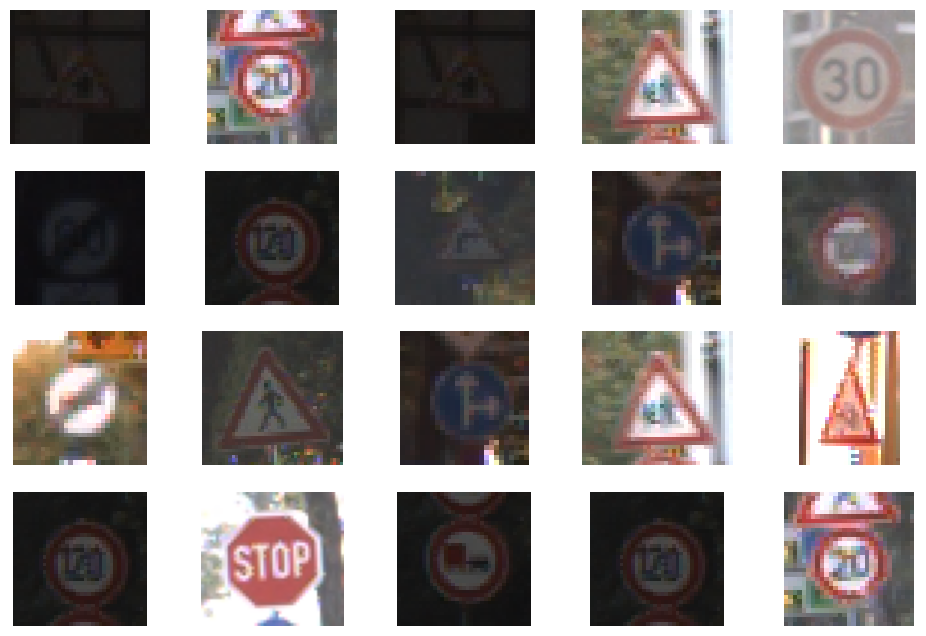

In [11]:
folder_names = [os.path.join(train_data_path, str(i)) for i in random.choices(range(43), k=20)]
file_names = [os.path.join(fldr, os.listdir(fldr)[0]) for fldr in folder_names]

fig, axes = plt.subplots(4, 5, figsize=(12, 8))
for i, image_path in enumerate(file_names):
    image = Image.open(image_path)
    row = i // 5
    col = i % 5
    axes[row, col].imshow(image)
    axes[row, col].axis('off')

plt.show();

# Building Custom Dataset for Traffic signs

In [12]:
# Transforming the Data ToTensor and Normalize it 

transforms = T.Compose([T.ToTensor(), T.Resize((225, 225)),
                        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [13]:
class TSignsDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):
        self.df = df
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, self.df.iloc[index, 7])  #the column of paths in df is 7
        image = Image.open(image_path)
        y_class = torch.tensor(self.df.iloc[index, 6])  #the column of ClsassId in df is 6

        if self.transform:
            image = self.transform(image)

        return (image, y_class)

In [14]:
training_set = TSignsDataset(train_df, traffic_sign_dataset_dir, transform=transforms)
validation_set = TSignsDataset(test_df, traffic_sign_dataset_dir, transform=transforms)

# Loading The data into DataLoaders

In [15]:
"""
#splitting the data into training and validation sets

L = len(training_set)
Len = int(0.8*L)
train_set, val_set = torch.utils.data.random_split(training_set,[Len,int(L-Len)])
"""

'\n#splitting the data into training and validation sets\n\nL = len(training_set)\nLen = int(0.8*L)\ntrain_set, val_set = torch.utils.data.random_split(training_set,[Len,int(L-Len)])\n'

In [16]:
#Loading the data into DataLoader

def getDataloaders (batch_size):
    train_loader = DataLoader(dataset=training_set, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(dataset=validation_set, batch_size=batch_size, shuffle=False)
    dataloaders = {'training': train_loader, 'validation': valid_loader}
    return dataloaders



# ResNet Explained

**ResNet is a type of CNN.It was designed to tackle the issue of vanishing gradients in deep networks, which was a major hindrance in developing deep neural networks. Its architecture enables the network to learn multiple layers of features without getting stuck in local minima.**

### Here are the key features of the ResNet (Residual Network) architecture:

* Residual Connections: ResNet incorporates residual connections, which allow for training very deep neural networks and alleviate the vanishing gradient problem. 

* Identity Mapping: ResNet uses identity mapping as the residual function, which makes the training process easier by learning the residual mapping rather than the actual mapping.

* Depth: ResNet enables the creation of very deep neural networks, which can improve performance on image recognition tasks. 

* Fewer Parameters: ResNet achieves better results with fewer parameters, making it computationally more efficient.

* State-of-the-art Results: ResNet has achieved state-of-the-art results on various image recognition tasks and has become a widely used benchmark for image recognition tasks.

* General and Effective Approach: The authors conclude that residual connections are a general and effective approach for enabling deeper networks.

### How ResNet Works?

* ResNet works by adding residual connections to the network, which helps to maintain the information flow throughout the network and prevents the gradients from vanishing.

* The residual connection is a shortcut that allows the information to bypass one or more layers in the network and reach the output directly.

* The residual connection allows the network to learn the residual function and make small updates to the parameters, which enables the network to converge faster and achieve better performance.

* This enables the network to learn residual functions and helps the network to converge faster and achieve better performance.

* The residual connection is based on the idea that instead of trying to learn the complex mapping between the inputs and the outputs, it is easier to learn the residual function, which maps the inputs to the desired outputs.

### The Problem Statement
Deep Neural Networks provide more accuracy as the number of layers increases. But, when we go deeper into the network, the accuracy of the network decreases instead of increasing. An increase in the depth of the network increases the training error, which ultimately increases the test error. Because of this, the network cannot generalize well for new data, which becomes inefficient. This degradation indicates that the increase in the model layer does not aid the model’s performance.

### The solution
Adding more layers to a suitably deep model leads to higher training errors. The paper presents how architectural changes like residual learning tackle this degradation problem using residual networks. Residual Network adds an identity mapping between the layers. Applying identity mapping to the input will give the output the same as the input. The skip connections directly pass the input to the output, effectively allowing the network to learn an identity function. The paper presents a deep convolutional neural network architecture that solves the vanishing gradients problem and enables the training of deep networks. It showed that deep residual networks could be trained effectively, achieving improved accuracy on several benchmark datasets compared to previous state-of-the-art models.

### Residual learning


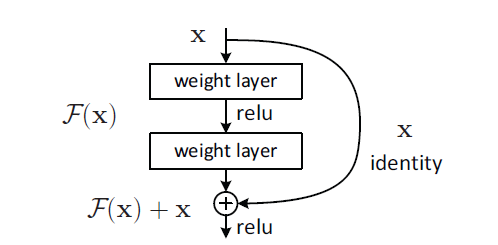

H(x) = F(x) + x
Where,
* X is the input to the set of layers
* F(x) is the residual function
* H(x) is the mapping function from input to output

### The Layer Blocks of the ResNet

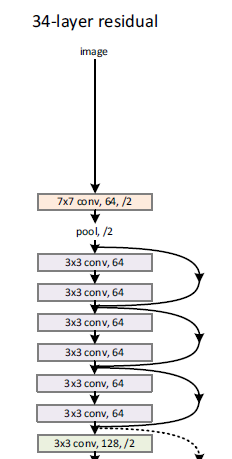 

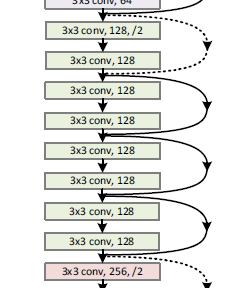 

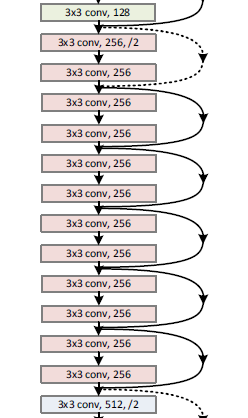 

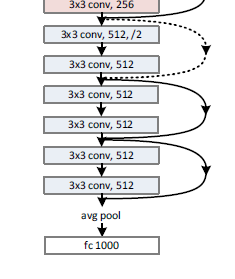

### The detailed architicture of the networks with different depth
50-layers = [3, 4, 6, 3]

101-layer = [3, 4, 23, 3]

152-layer = [3, 8, 36, 3]




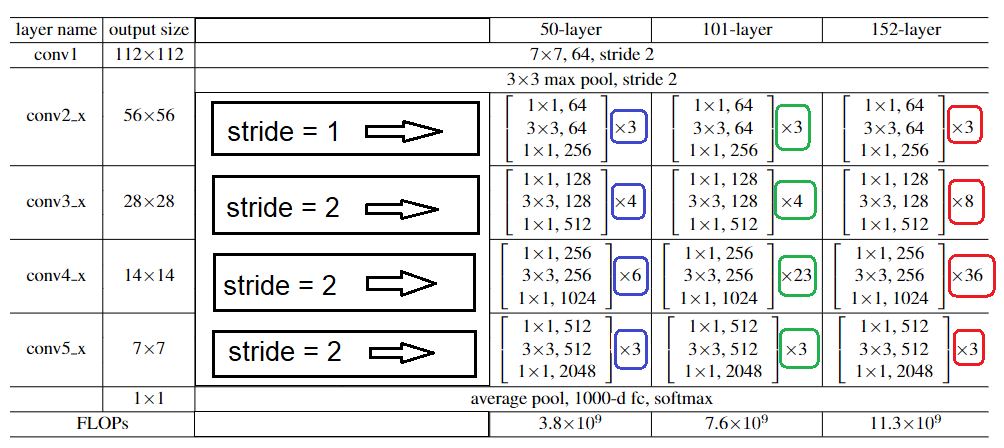

**note that the number of out_channels in the third conv layer is always 4*(out_channels) of the first and second,this factor is represented in the block class as (expansion = 4).**

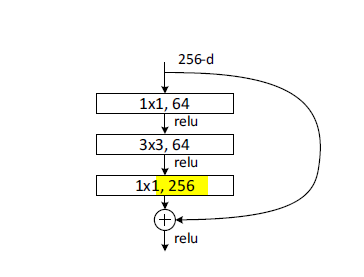



# Building The ResNet Model from scratch

### Generic Residual block 

In [17]:
class block(nn.Module):
    def __init__(
            self, in_channels, out_channels, identity_downsample=None, stride=1):
        super().__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False, )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0,
                               bias=False, )
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

### Generic implementation of ResNet Class

In [18]:
class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(block, layers[0], out_channels=64, stride=1)
        self.layer2 = self._make_layer(block, layers[1], out_channels=128, stride=2)
        self.layer3 = self._make_layer(block, layers[2], out_channels=256, stride=2)
        self.layer4 = self._make_layer(block, layers[3], out_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, out_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != out_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * 4, kernel_size=1, stride=stride, bias=False)
                , nn.BatchNorm2d(out_channels * 4))

        layers.append(block(self.in_channels, out_channels, identity_downsample, stride))

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = out_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

### The ResNet: 3 levels of depth

In [19]:
def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)

In [20]:
"""
# testing the network on random tensor

def test():
    BATCH_SIZE = 32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = ResNet50(img_channel=3, num_classes=43).to(device)
    y = net(torch.randn(BATCH_SIZE, 3, 225, 225)).to(device)
    assert y.size() == torch.Size([BATCH_SIZE, 43])
    print(y.size())

test()
"""

'\n# testing the network on random tensor\n\ndef test():\n    BATCH_SIZE = 32\n    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n    net = ResNet50(img_channel=3, num_classes=43).to(device)\n    y = net(torch.randn(BATCH_SIZE, 3, 225, 225)).to(device)\n    assert y.size() == torch.Size([BATCH_SIZE, 43])\n    print(y.size())\n\ntest()\n'

# Training The model

In [21]:
def Train(model, device, criterion, optimizer, num_epochs, batch_size, dataloaders, out_path):
    best_model_weights = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("epoch {}/{}".format(epoch + 1, num_epochs))
        print("*" * 10)

        for x in ["training", "validation"]:
            if x == "training":
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_accuracy = 0

            for data in dataloaders[x]:
                img, y = data
                img, y = img.to(device), y.to(device)
                print("Image is cuda: ", img.is_cuda)
                optimizer.zero_grad()
                y_pred = model(img)
                loss = criterion(y_pred, y)
                _, preds = torch.max(y_pred, dim=1)

                if x == 'training':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_accuracy += torch.sum(preds == y.data)

            epoch_loss = running_loss / len(dataloaders[x])
            epoch_acc = running_accuracy / len(dataloaders[x])

            print('{} Loss: {:.4f} || Accuracy: {:.4f}'.format(x, epoch_loss, epoch_acc))

            # deep copy the model
            if x == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc

    # load best model weights
    torch.save(model.state_dict(), out_path)
    return print('Best validation Accuracy: {:4f}'.format(best_acc))

In [45]:
# print(os.getenv("PYTORCH_CUDA_ALLOC_CONF"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device is:", device)
model = ResNet50(img_channel=3, num_classes=43)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5
batch_size = 4
out_path = os.path.join(os.getcwd(), "traffic_sign_model/best_model"+ "_cuda.pt" if torch.cuda.is_available() else "_cpu.pt")

#train the model
# Train(model, device, criterion, optimizer, num_epochs, batch_size, getDataloaders(batch_size), out_path)

device is: cuda


# Loading The trained Model 

In [46]:
model.load_state_dict(torch.load(out_path))

<All keys matched successfully>



# References

* Deep Residual Learning for Image Recognition: https://arxiv.org/abs/1512.03385
* ResNet Explained :https://www.analyticsvidhya.com/blog/2023/02/deep-residual-learning-for-image-recognition-resnet-explained/
* Pytorch ResNet implementation from Scratch: https://www.youtube.com/watch?v=DkNIBBBvcPs

In [47]:
#
# Resnet is required to be put in evaluation mode in order
# to do prediction / evaluation
#
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [48]:
from torchvision import transforms
#
# Create a preprocessing pipeline
#
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])


In [49]:
import os
# img_path = os.path.join(os.path.dirname((os.getcwd())), "dataset/test_data/test1.jpg")
img_path = "/home/a-schulz/kaggle/gtsrb-german-traffic-sign/Meta/2.png"

In [50]:
# Using cv2 to load image
# import cv2

# # Function to load and transform the image
# def load_and_transform_image(image_path):
#     # Load the image using OpenCV
#     image = cv2.imread(image_path)

#     # Convert the image from BGR (OpenCV's default) to RGB
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # Define the transformations to be applied
#     transform = transforms.Compose([
#         transforms.ToPILImage(),              # Convert NumPy array to PIL Image
#         transforms.Resize((224, 224)),        # Resize the image to 224x224 pixels
#         transforms.ToTensor(),                # Convert PIL Image to PyTorch Tensor
#         transforms.Normalize(                 # Normalize the image with mean and standard deviation
#             mean=[0.485, 0.456, 0.406],       # These values are for ImageNet-pretrained models
#             std=[0.229, 0.224, 0.225]
#         ),
#     ])

#     # Apply the transformations to the image
#     transformed_image = transform(image)

#     return transformed_image



# if os.path.isfile(img_path):
#     img = load_and_transform_image(img_path)

# #
# # Reshape, crop, and normalize the input tensor for feeding into network for evaluation
# #
# batch_img_cat_tensor = torch.unsqueeze(img, 0)

# #
# # Get the predictions of image as scores related to how the loaded image
# # matches with 1000 ImageNet classes. The variable, out is a vector of 1000 scores
# #
# out = model(batch_img_cat_tensor)

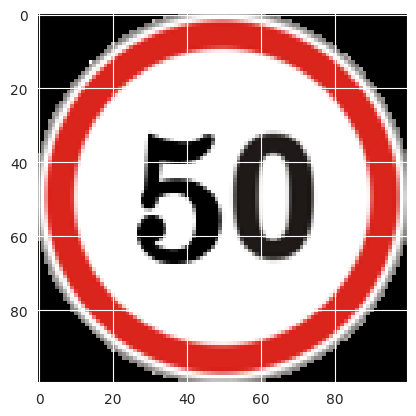

In [51]:
# Load the image
from PIL import Image
img_cat = Image.open(img_path).convert('RGB')
plt.imshow(img_cat)
# Pass the image for preprocessing and the image preprocessed
img_cat_preprocessed = preprocess(img_cat)
img_cat_preprocessed = img_cat_preprocessed.to(device)  # Move tensor to the same device as the model

# Reshape, crop, and normalize the input tensor for feeding into the network for evaluation
batch_img_cat_tensor = torch.unsqueeze(img_cat_preprocessed, 0)

# Make sure the model is on the same device as the input tensor
model.to(device)

# Get the predictions of the image
out = model(batch_img_cat_tensor)

In [52]:
with open(os.path.join(os.getcwd(),'traffic_sign_model/classid_label.csv')) as f:
    labels = [line.strip() for line in f.readlines()]
#
# Find the index (tensor) corresponding to the maximum score in the out tensor.
# Torch.max function can be used to find the information
#
_, index = torch.max(out, 1)
#
# Find the score in terms of percentage by using torch.nn.functional.softmax function
# which normalizes the output to range [0,1] and multiplying by 100
#
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
#
# Print the name along with score of the object identified by the model
#
print(labels[index[0]], percentage[index[0]].item())
#
# Print the top 5 scores along with the image label. Sort function is invoked on the torch to sort the scores.
#
_, indices = torch.sort(out, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

41,end no overtaking 99.99998474121094


[('41,end no overtaking', 99.99998474121094),
 ('37,must turn left or straight', 1.777789839252364e-05),
 ('1,30 km/h', 2.494890338766709e-07),
 ('38,drive along right', 5.420665516453482e-08),
 ('39,drive along left', 3.71897641571195e-08)]